# Plot Nedelec condition-specific eQTLs that overlapped with Neanderthal dataset

This code plots the expression data of macrophage condition-specific eQTLs from Nedelec *et al.* for which the same variant has been identified as Neanderthal-introgressed by Dannemann *et al.* and/or Simonti *et al.* Gene expression levels were compared between African and European individuals via a two-sided T-test.

Neanderthal SNPs from:
1. Dannemann M, Prufer K & Kelso J. Functional implications of Neandertal introgression in modern humans. Genome Biol 2017 18:61.
2. Simonti CN *et al.* The phenotypic legacy of admixture between modern humans and Neandertals. Science 2016 351:737-41.

Macrophages eQTLs from:
1. Nedelec Y *et al.* Genetic Ancestry and Natural Selection Drive Population Differences in Immune Responses to Pathogens. Cell 2016 167:657-669 e21.

In [1]:
# Import libraries
import pandas as pd
from plinkio import plinkfile
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

### Load datasets

In [2]:
# Load Nedelec expression data
expr_info = pd.read_csv('expr_info_gtf_GRCh37.75.txt', index_col=0)
expr_all = pd.read_csv('Normalised_count_data.txt', index_col=0)

# Subset by experimental condition
expr_NI = expr_all.loc[:, expr_all.columns.str.contains('non_infected')]
expr_NI.columns = expr_NI.columns.str.rstrip('_non_infected')
expr_LIS = expr_all.loc[:, expr_all.columns.str.contains('listeria')]
expr_LIS.columns = expr_LIS.columns.str.rstrip('_listeria')
expr_SAL = expr_all.loc[:, expr_all.columns.str.contains('salmonella')]
expr_SAL.columns = expr_SAL.columns.str.rstrip('_salmonella')

In [3]:
# Sample list
samp_ls = list(expr_NI.columns.values)
samples = {'African':[], 'European': []}
for samp in samp_ls:
    if 'AF' in samp:
        samples['African'].append(samp)
    else:
        samples['European'].append(samp)

In [4]:
# Subset intersecting SNPs in Neanderthal & Nedelec datasets by experimental conditions
allpop_df = pd.read_csv("../neanderthal/allpop_df.csv", usecols=["Chromosome", "Position", "Source", "ID", "Major"])
allpop_df = allpop_df.dropna()
ned_eqtl = pd.read_excel("nedelec_eQTL.xlsx", "A) cis eQTL", skiprows=[0,1])
ned_eqtl.columns = ned_eqtl.iloc[0, :]
ned_eqtl.drop(ned_eqtl.index[0], inplace=True)
ned_eqtl.rename(columns={"external_gene_name": "Gene"}, inplace=True)

# Not infected
ni = ned_eqtl.loc[:, ["ensembl_gene_id", "Gene", "NI_top_snp_id", "NI_pvalue"]]
ni.rename(columns={"ensembl_gene_id": "Ensembl", "NI_top_snp_id": "ID", "NI_pvalue": "p.value"}, inplace=True)
ni = ni.merge(allpop_df, how='inner', on=['ID'])

# Listeria
lis = ned_eqtl.loc[:, ["ensembl_gene_id", "Gene", "L_top_snp_id", "L_pvalue"]]
lis.rename(columns={"ensembl_gene_id": "Ensembl", "L_top_snp_id": "ID", "L_pvalue": "p.value"}, inplace=True)
lis = lis.merge(allpop_df, how='inner', on=['ID'])

# Salmonella
sal = ned_eqtl.loc[:, ["ensembl_gene_id", "Gene", "S_top_snp_id","S_pvalue" ]]
sal.rename(columns={"ensembl_gene_id": "Ensembl", "S_top_snp_id": "ID", "S_pvalue": "p.value"}, inplace=True)
sal = sal.merge(allpop_df, how='inner', on=['ID'])

### Expression plots

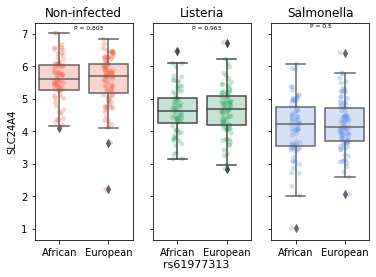

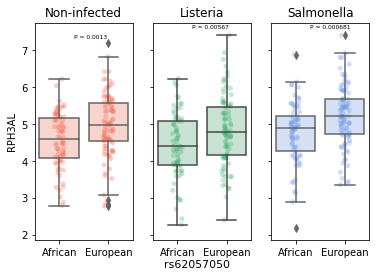

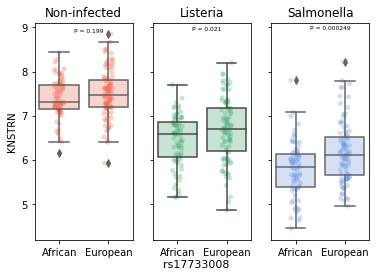

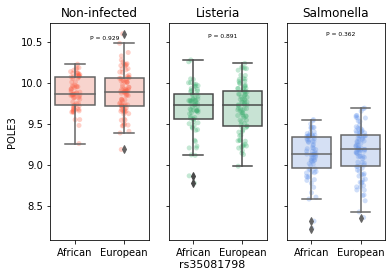

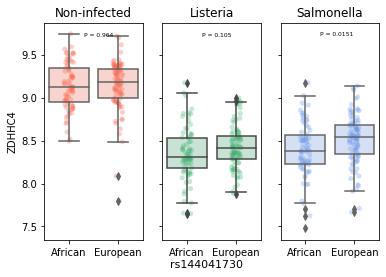

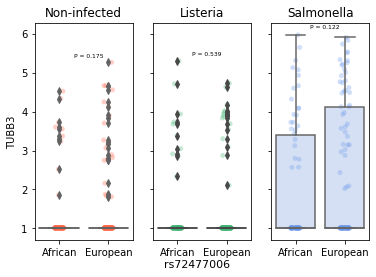

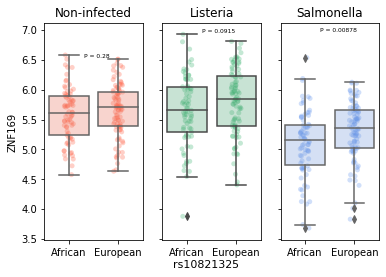

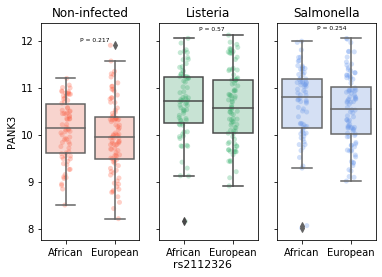

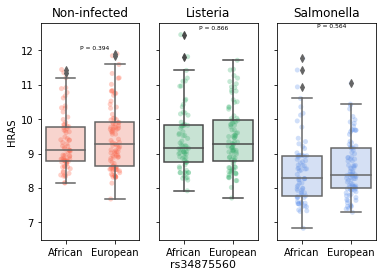

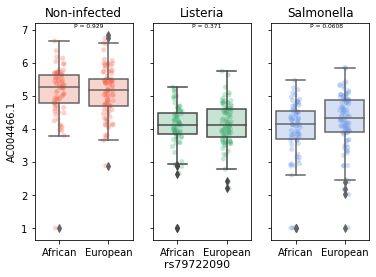

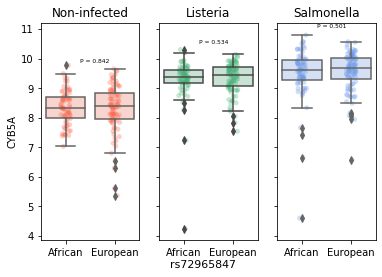

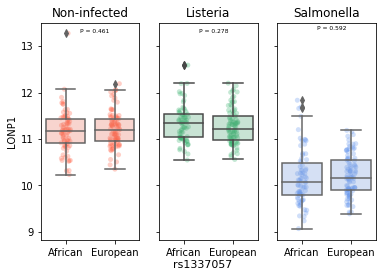

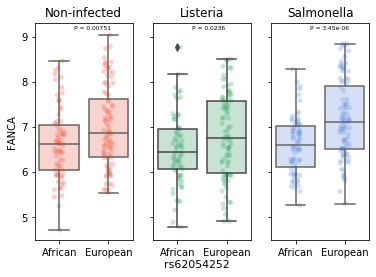

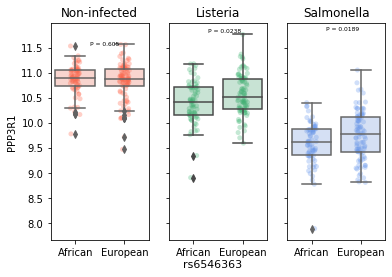

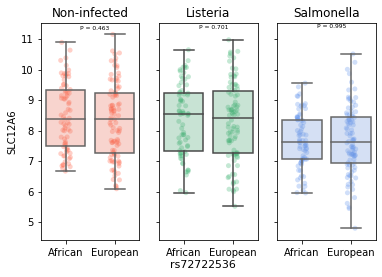

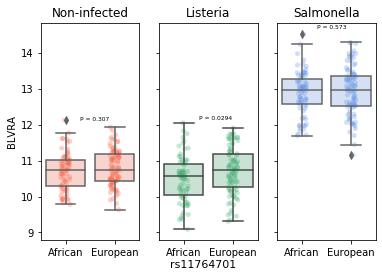

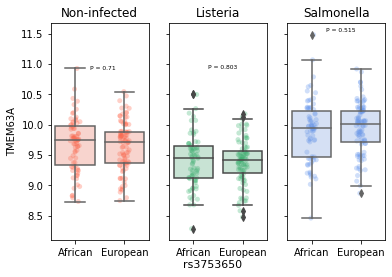

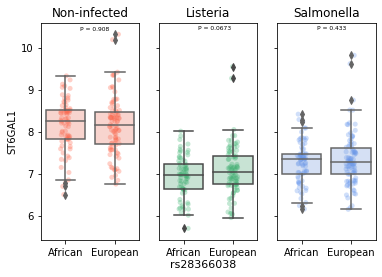

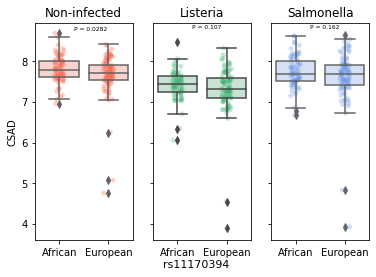

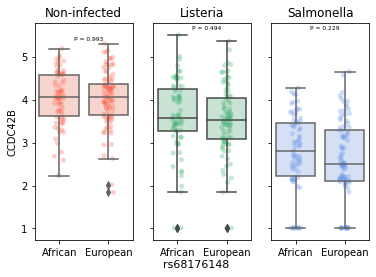

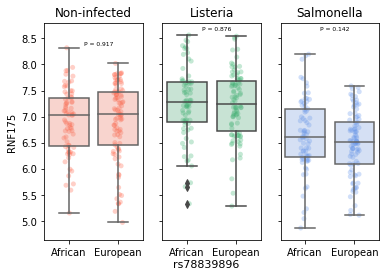

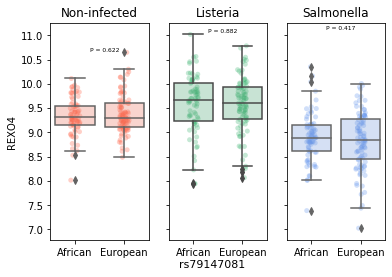

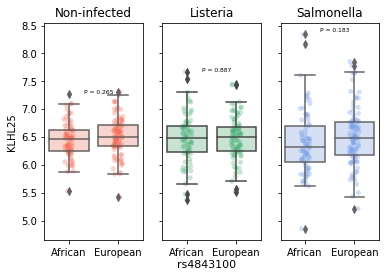

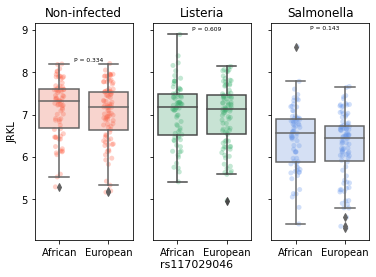

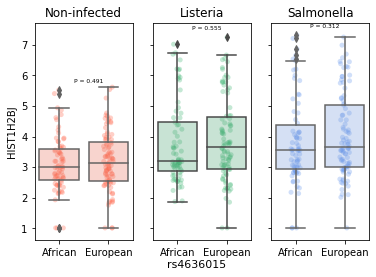

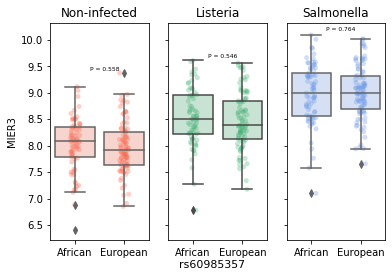

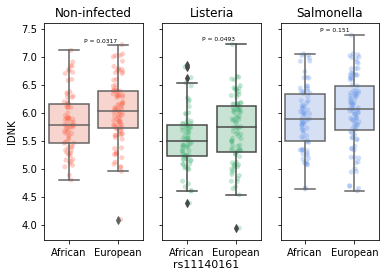

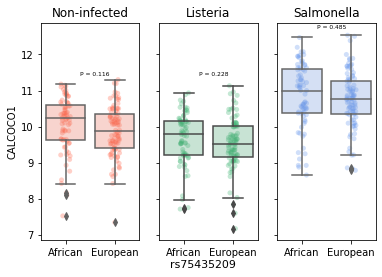

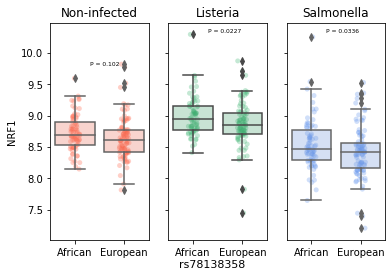

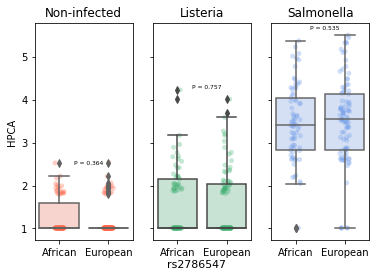

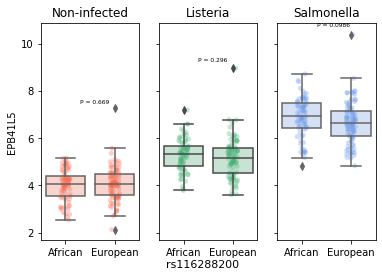

In [5]:
# Salmonella-infected
missing_genes = []
sig = []
for gene, snp in zip(sal.Gene, sal.ID):

    # Gene's array address
    if gene in expr_info.gene_name.values:
        array_address = expr_info[expr_info.gene_name == gene].index.values[0]

        # Cross expression of the gene with each combination of alleles
        expr_ni = {}
        expr_lis = {}
        expr_sal = {}
        for pop in samples:
            temp_ni = []
            temp_lis = []
            temp_sal = []
            for samp in samples[pop]:
                if samp in expr_NI.columns.values:
                    temp_ni.append(expr_NI.loc[array_address, samp])
                if samp in expr_LIS.columns.values:
                    temp_lis.append(expr_LIS.loc[array_address, samp])
                if samp in expr_SAL.columns.values:
                    temp_sal.append(expr_SAL.loc[array_address, samp])
            expr_ni[pop] = temp_ni
            expr_lis[pop] = temp_lis
            expr_sal[pop] = temp_sal

        # Build dataframe
        # Non-infected
        ni_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_ni.items() if len(v) > 0]))
        ni_melt = pd.melt(ni_df, var_name=snp, value_name=gene)
        ni_melt['Context'] = 'Non-infected'
        # Listeria
        lis_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_lis.items() if len(v) > 0]))
        lis_melt = pd.melt(lis_df, var_name=snp, value_name=gene)
        lis_melt['Context'] = 'Listeria'
        # Salmonella
        sal_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_sal.items() if len(v) > 0]))
        sal_melt = pd.melt(sal_df, var_name=snp, value_name=gene)
        sal_melt['Context'] = 'Salmonella'
        # Concatenate dfs
        exp_df = pd.concat([ni_melt, lis_melt, sal_melt])

        # Plot
        colors = ['tomato', 'mediumseagreen', 'cornflowerblue']
        context = ['Non-infected', 'Listeria', 'Salmonella']
        order = ['African', 'European']
        
        fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True)
        for ax in axes:
            i = list(axes).index(ax)
            grp = context[i]
            f = sns.stripplot(x=snp, y=gene, data=exp_df[exp_df['Context'] == grp], ax=ax, color=colors[i], alpha=0.3, zorder=0, order=order)
            g = sns.boxplot(x=snp, y=gene, data=exp_df[exp_df['Context'] == grp], ax=ax, color=colors[i], order=order)
            for patch in g.artists:
                r, g, b, a = patch.get_facecolor()
                patch.set_facecolor((r, g, b, 0.3))
            ax.set_title(grp)
            ax.set_xlabel('')
            if i > 0:
                ax.set_ylabel('')
                
            # Perform t-test and annotate p-value
            if i == 0:
                t, p = stats.ttest_ind(ni_df['African'], ni_df['European'], nan_policy='omit') 
                # Get gene-snp pairs with significant t-test p-values
                if p < 0.05 and (gene, snp) not in sig:
                    sig.append((gene, snp))
                p = format(p, '.3g')
                y = ax.get_ylim()[1] - 0.15
                ax.text(0.3, y, 'P = ' + p, fontsize=6)
            if i == 1:
                t, p = stats.ttest_ind(lis_df['African'], lis_df['European'], nan_policy='omit')
                if p < 0.05 and (gene, snp) not in sig:
                    sig.append((gene, snp))
                p = format(p, '.3g')
                y = ax.get_ylim()[1] - 0.15
                ax.text(0.3, y, 'P = ' + p, fontsize=6)
            if i == 2:
                t, p = stats.ttest_ind(sal_df['African'], sal_df['European'], nan_policy='omit')
                if p < 0.05 and (gene, snp) not in sig:
                    sig.append((gene, snp))
                p = format(p, '.3g')
                y = ax.get_ylim()[1] - 0.15
                ax.text(0.3, y, 'P = ' + p, fontsize=6)
                
        fig.text(0.5, 0.04, snp, ha='center', va='center', fontsize=11)
        plt.show()
        
        # Get eQTL p-value and label saved plot with 'p' if p < 10e-8
        p_eqtl = sal.query("ID == @snp and Gene == @gene")['p.value'].item()
        if float(p_eqtl) < 10e-8:
            fig.savefig('nedelec/figs/SAL/p_' + gene + '_' + snp + '_boxplot.pdf')
        else:
            fig.savefig('nedelec/figs/SAL/' + gene + '_' + snp + '_boxplot.pdf')

    # Get genes that could not be found
    else:
        missing_genes.append((gene, snp))

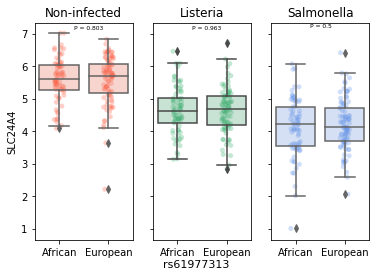

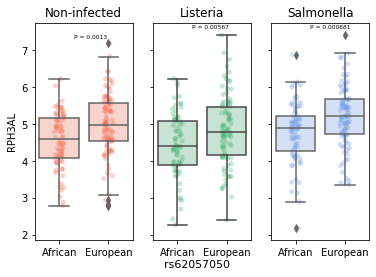

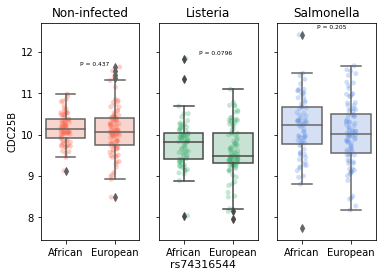

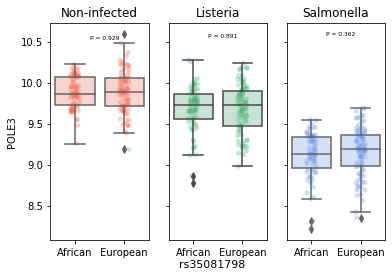

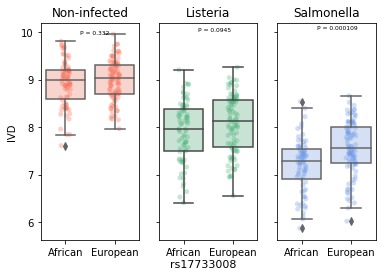

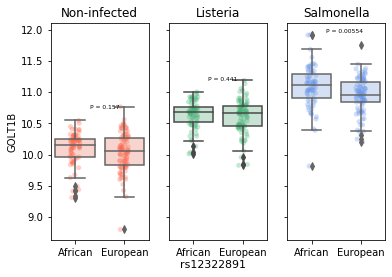

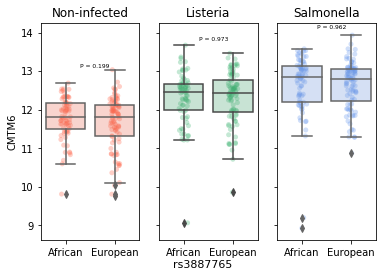

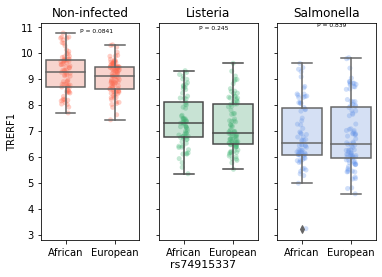

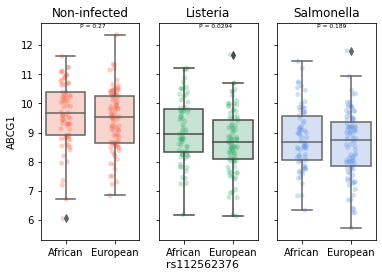

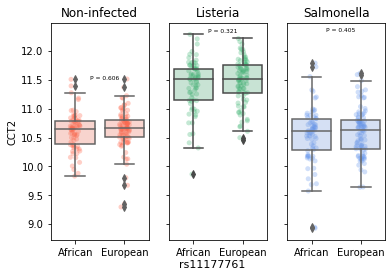

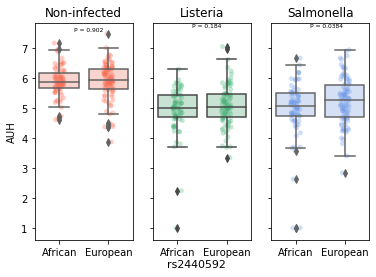

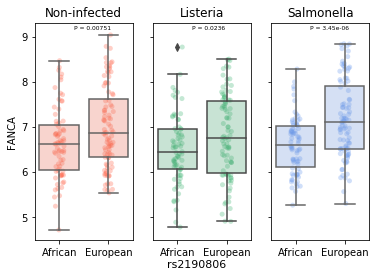

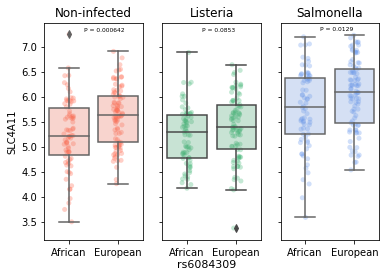

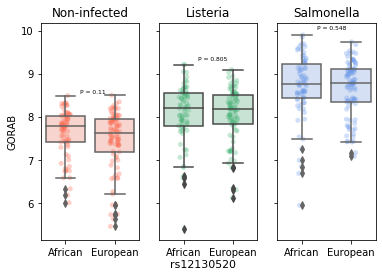

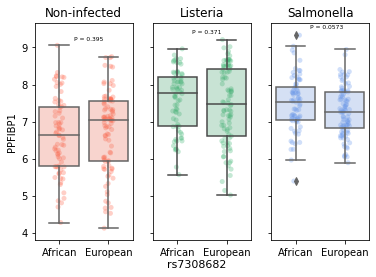

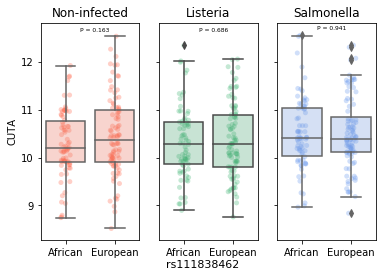

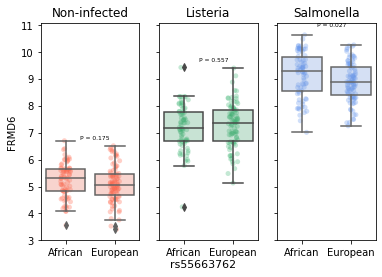

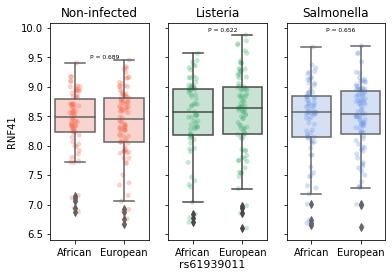

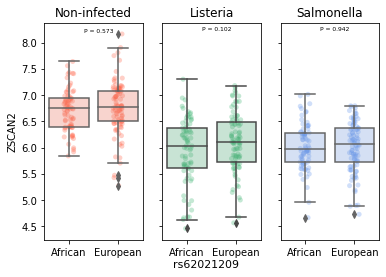

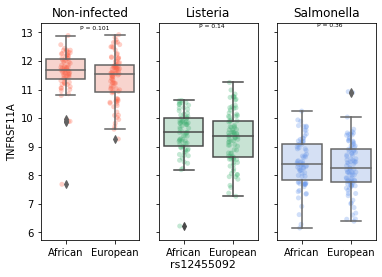

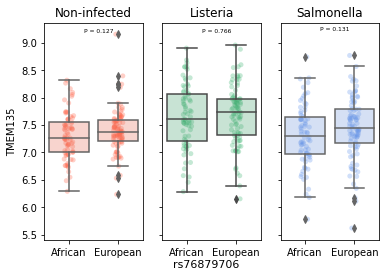

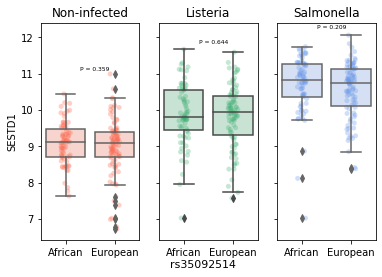

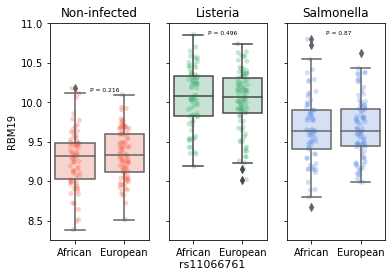

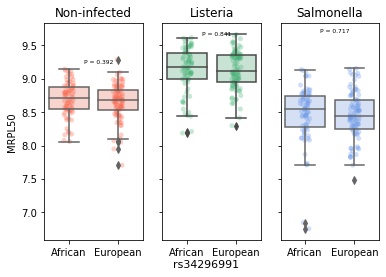

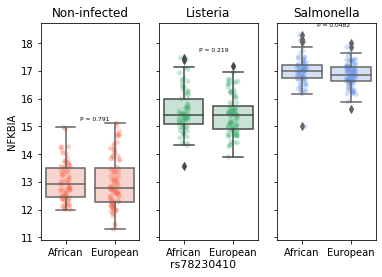

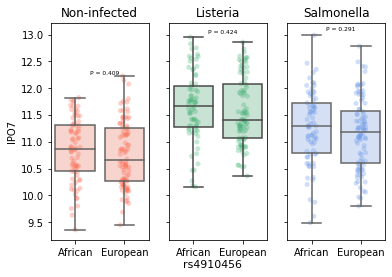

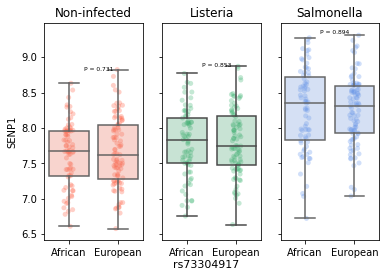

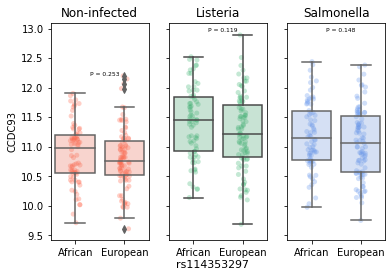

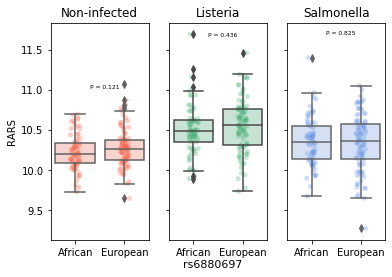

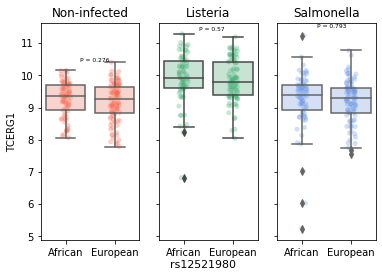

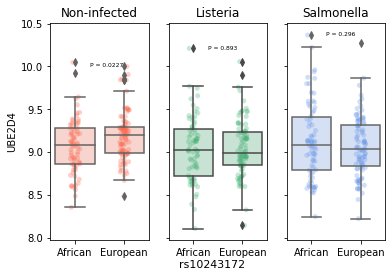

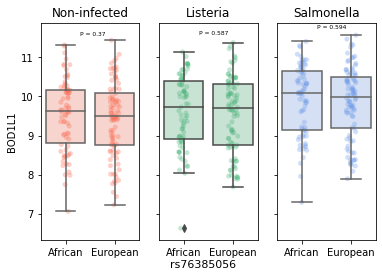

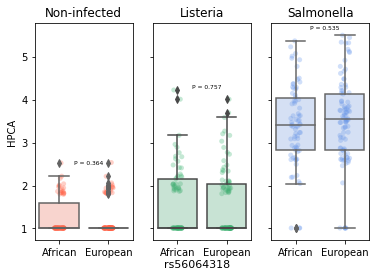

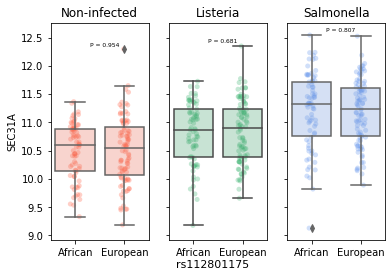

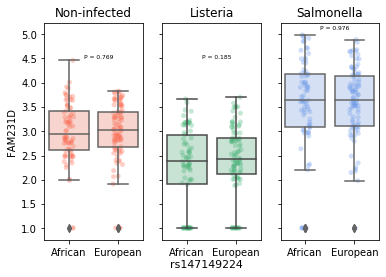

In [6]:
# Listeria-infected
missing_genes = []
sig = []
for gene, snp in zip(lis.Gene, lis.ID):

    # Gene's array address
    if gene in expr_info.gene_name.values:
        array_address = expr_info[expr_info.gene_name == gene].index.values[0]

        # Cross expression of the gene with each combination of alleles
        expr_ni = {}
        expr_lis = {}
        expr_sal = {}
        for pop in samples:
            temp_ni = []
            temp_lis = []
            temp_sal = []
            for samp in samples[pop]:
                if samp in expr_NI.columns.values:
                    temp_ni.append(expr_NI.loc[array_address, samp])
                if samp in expr_LIS.columns.values:
                    temp_lis.append(expr_LIS.loc[array_address, samp])
                if samp in expr_SAL.columns.values:
                    temp_sal.append(expr_SAL.loc[array_address, samp])
            expr_ni[pop] = temp_ni
            expr_lis[pop] = temp_lis
            expr_sal[pop] = temp_sal

        # Build dataframe
        # Non-infected
        ni_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_ni.items() if len(v) > 0]))
        ni_melt = pd.melt(ni_df, var_name=snp, value_name=gene)
        ni_melt['Context'] = 'Non-infected'
        # Listeria
        lis_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_lis.items() if len(v) > 0]))
        lis_melt = pd.melt(lis_df, var_name=snp, value_name=gene)
        lis_melt['Context'] = 'Listeria'
        # Salmonella
        sal_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_sal.items() if len(v) > 0]))
        sal_melt = pd.melt(sal_df, var_name=snp, value_name=gene)
        sal_melt['Context'] = 'Salmonella'
        # Concatenate dfs
        exp_df = pd.concat([ni_melt, lis_melt, sal_melt])

        # Plot
        colors = ['tomato', 'mediumseagreen', 'cornflowerblue']
        context = ['Non-infected', 'Listeria', 'Salmonella']
        order = ['African', 'European']
        
        fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True)
        for ax in axes:
            i = list(axes).index(ax)
            grp = context[i]
            f = sns.stripplot(x=snp, y=gene, data=exp_df[exp_df['Context'] == grp], ax=ax, color=colors[i], alpha=0.3, zorder=0, order=order)
            g = sns.boxplot(x=snp, y=gene, data=exp_df[exp_df['Context'] == grp], ax=ax, color=colors[i], order=order)
            for patch in g.artists:
                r, g, b, a = patch.get_facecolor()
                patch.set_facecolor((r, g, b, 0.3))
            ax.set_title(grp)
            ax.set_xlabel('')
            if i > 0:
                ax.set_ylabel('')
                
            # Perform t-test and annotate p-value
            if i == 0:
                t, p = stats.ttest_ind(ni_df['African'], ni_df['European'], nan_policy='omit') 
                # Get gene-snp pairs with significant t-test p-values
                if p < 0.05 and (gene, snp) not in sig:
                    sig.append((gene, snp)) 
                p = format(p, '.3g')
                y = ax.get_ylim()[1] - 0.15
                ax.text(0.3, y, 'P = ' + p, fontsize=6)
            if i == 1:
                t, p = stats.ttest_ind(lis_df['African'], lis_df['European'], nan_policy='omit')
                if p < 0.05 and (gene, snp) not in sig:
                    sig.append((gene, snp))
                p = format(p, '.3g')
                y = ax.get_ylim()[1] - 0.15
                ax.text(0.3, y, 'P = ' + p, fontsize=6)
            if i == 2:
                t, p = stats.ttest_ind(sal_df['African'], sal_df['European'], nan_policy='omit')
                if p < 0.05 and (gene, snp) not in sig:
                    sig.append((gene, snp))
                p = format(p, '.3g')
                y = ax.get_ylim()[1] - 0.15
                ax.text(0.3, y, 'P = ' + p, fontsize=6)
                
        fig.text(0.5, 0.04, snp, ha='center', va='center', fontsize=11)
        plt.show()
        
        # Get eQTL p-value and label saved plot with 'p' if p < 10e-8
        p_eqtl = lis.query("ID == @snp and Gene == @gene")['p.value'].item()
        if float(p_eqtl) < 10e-8:
            fig.savefig('nedelec/figs/LIS/p_' + gene + '_' + snp + '_boxplot.pdf')
        else:
            fig.savefig('nedelec/figs/LIS/' + gene + '_' + snp + '_boxplot.pdf')

    # Get genes that could not be found
    else:
        missing_genes.append((gene, snp))

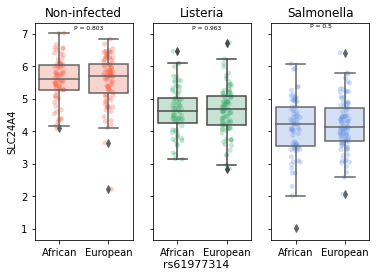

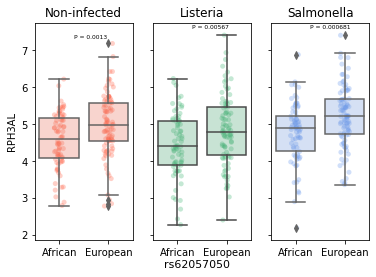

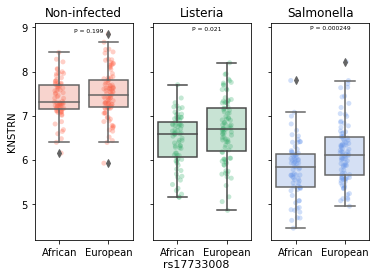

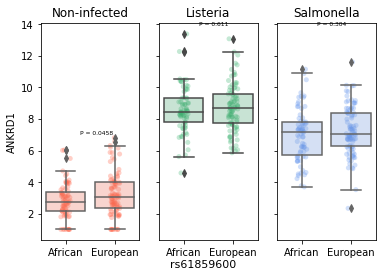

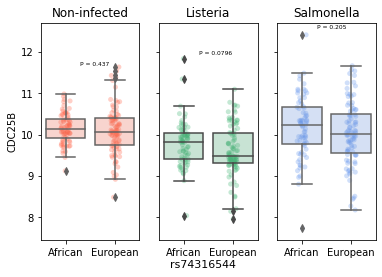

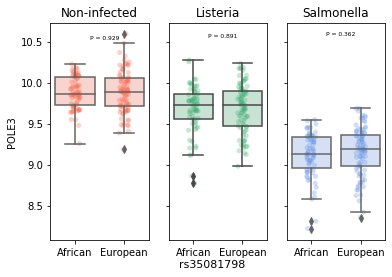

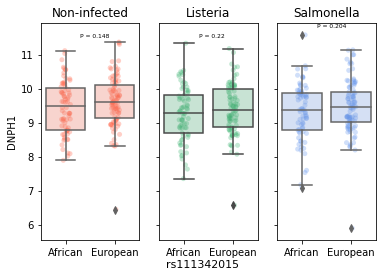

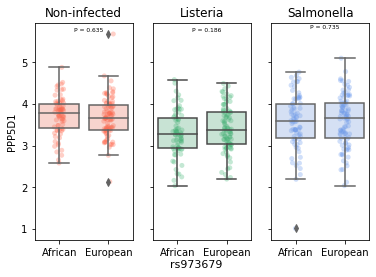

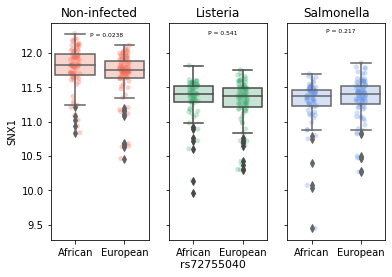

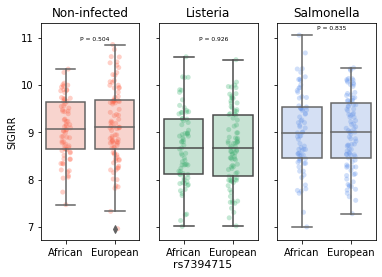

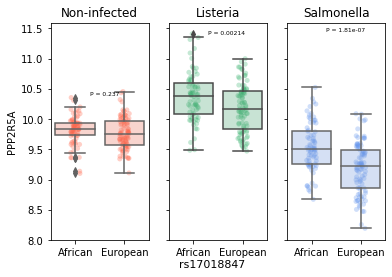

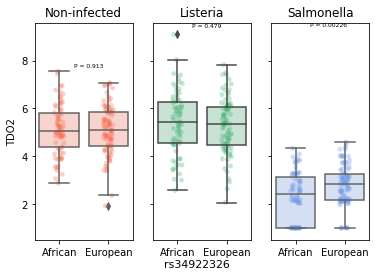

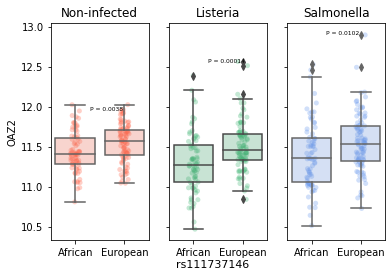

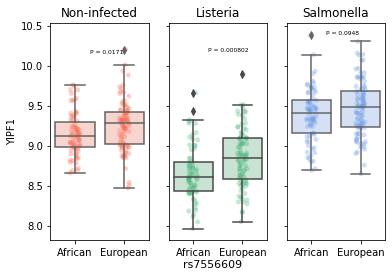

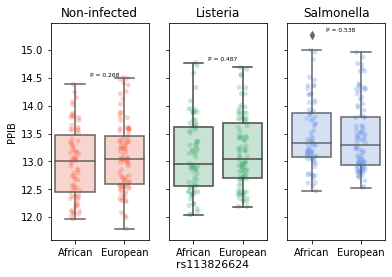

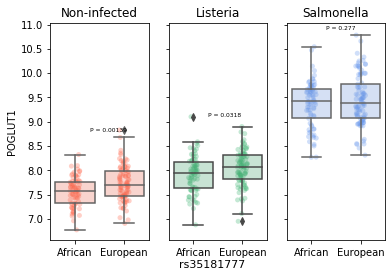

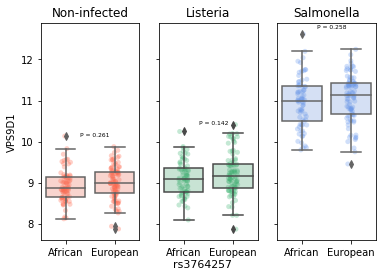

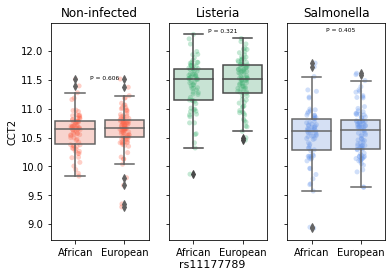

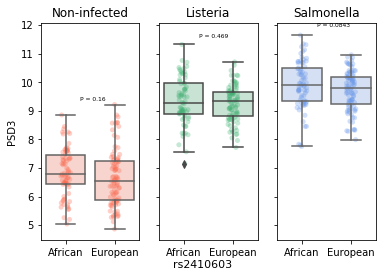

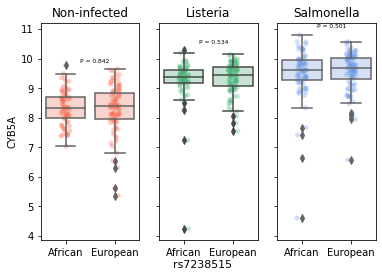

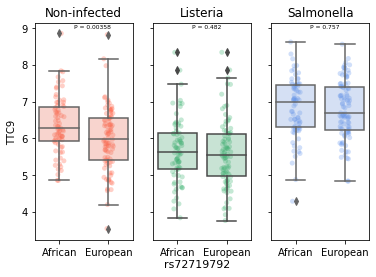

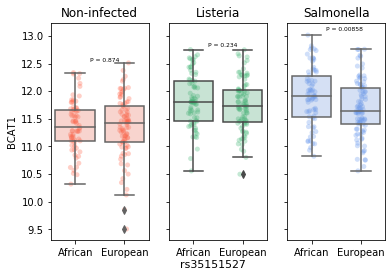

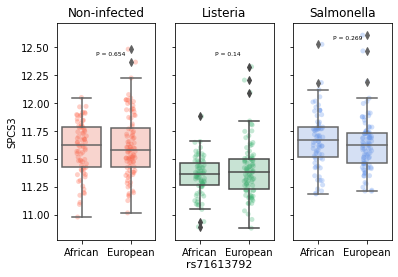

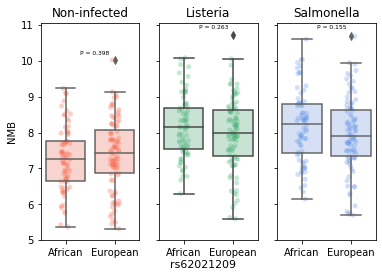

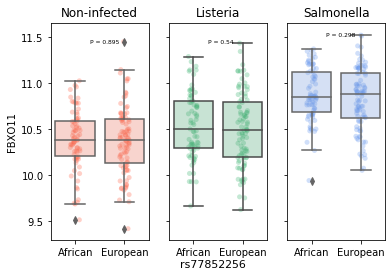

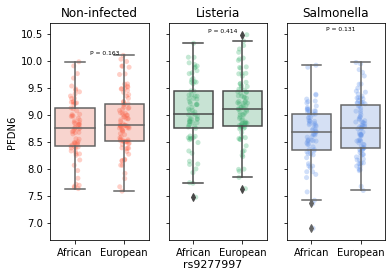

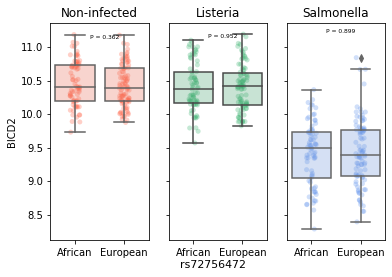

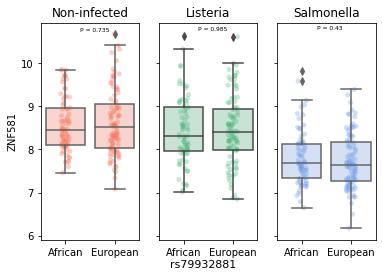

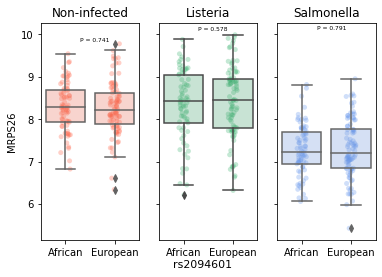

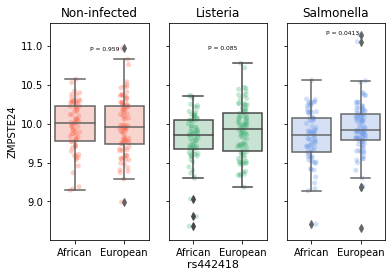

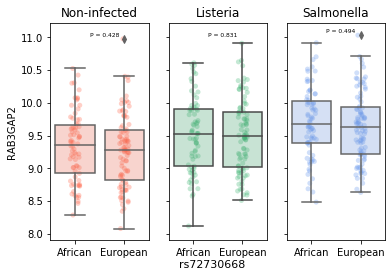

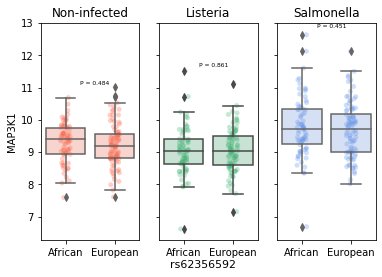

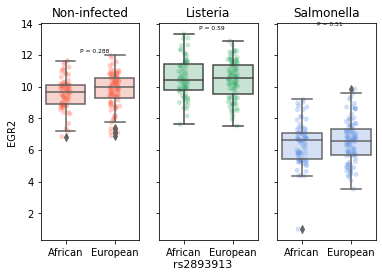

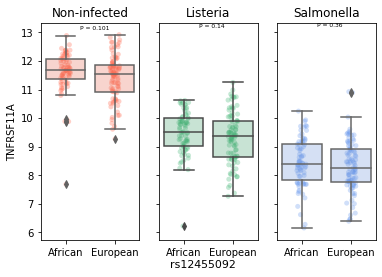

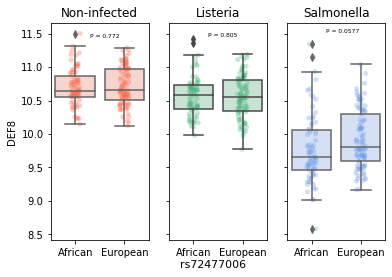

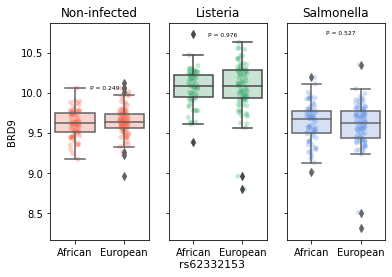

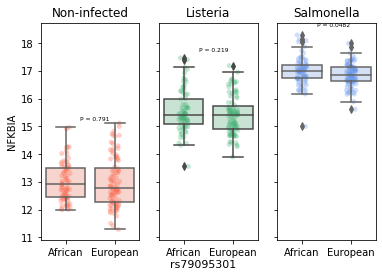

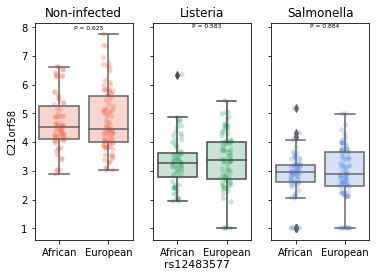

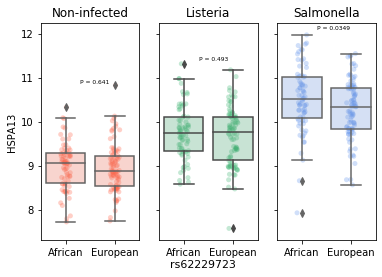

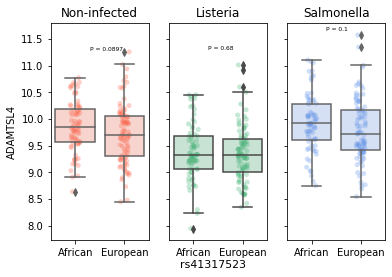

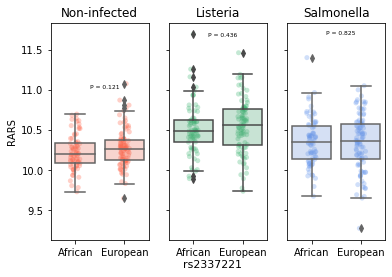

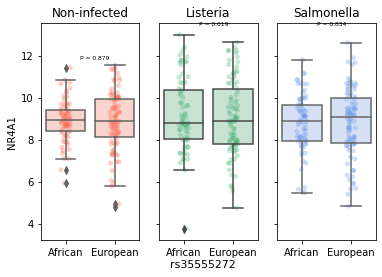

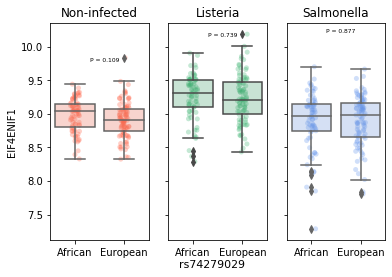

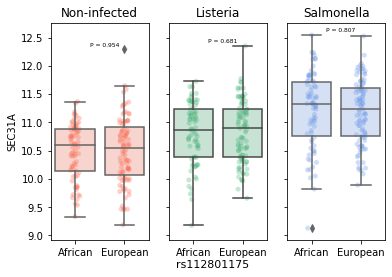

In [7]:
# Non-infected
missing_genes = []
sig = []
for gene, snp in zip(ni.Gene, ni.ID):

    # Gene's array address
    if gene in expr_info.gene_name.values:
        array_address = expr_info[expr_info.gene_name == gene].index.values[0]

        # Cross expression of the gene with each combination of alleles
        expr_ni = {}
        expr_lis = {}
        expr_sal = {}
        for pop in samples:
            temp_ni = []
            temp_lis = []
            temp_sal = []
            for samp in samples[pop]:
                if samp in expr_NI.columns.values:
                    temp_ni.append(expr_NI.loc[array_address, samp])
                if samp in expr_LIS.columns.values:
                    temp_lis.append(expr_LIS.loc[array_address, samp])
                if samp in expr_SAL.columns.values:
                    temp_sal.append(expr_SAL.loc[array_address, samp])
            expr_ni[pop] = temp_ni
            expr_lis[pop] = temp_lis
            expr_sal[pop] = temp_sal

        # Build dataframe
        # Non-infected
        ni_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_ni.items() if len(v) > 0]))
        ni_melt = pd.melt(ni_df, var_name=snp, value_name=gene)
        ni_melt['Context'] = 'Non-infected'
        # Listeria
        lis_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_lis.items() if len(v) > 0]))
        lis_melt = pd.melt(lis_df, var_name=snp, value_name=gene)
        lis_melt['Context'] = 'Listeria'
        # Salmonella
        sal_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in expr_sal.items() if len(v) > 0]))
        sal_melt = pd.melt(sal_df, var_name=snp, value_name=gene)
        sal_melt['Context'] = 'Salmonella'
        # Concatenate dfs
        exp_df = pd.concat([ni_melt, lis_melt, sal_melt])

        # Plot
        colors = ['tomato', 'mediumseagreen', 'cornflowerblue']
        context = ['Non-infected', 'Listeria', 'Salmonella']
        order = ['African', 'European']
        
        fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True)
        for ax in axes:
            i = list(axes).index(ax)
            grp = context[i]
            f = sns.stripplot(x=snp, y=gene, data=exp_df[exp_df['Context'] == grp], ax=ax, color=colors[i], alpha=0.3, zorder=0, order=order)
            g = sns.boxplot(x=snp, y=gene, data=exp_df[exp_df['Context'] == grp], ax=ax, color=colors[i], order=order)
            for patch in g.artists:
                r, g, b, a = patch.get_facecolor()
                patch.set_facecolor((r, g, b, 0.3))
            ax.set_title(grp)
            ax.set_xlabel('')
            if i > 0:
                ax.set_ylabel('')
                
            # Perform t-test and annotate p-value
            if i == 0:
                t, p = stats.ttest_ind(ni_df['African'], ni_df['European'], nan_policy='omit') 
                # Get gene-snp pairs with significant t-test p-values
                if p < 0.05 and (gene, snp) not in sig:
                    sig.append((gene, snp)) 
                p = format(p, '.3g')
                y = ax.get_ylim()[1] - 0.15
                ax.text(0.3, y, 'P = ' + p, fontsize=6)
            if i == 1:
                t, p = stats.ttest_ind(lis_df['African'], lis_df['European'], nan_policy='omit')
                if p < 0.05 and (gene, snp) not in sig:
                    sig.append((gene, snp))
                p = format(p, '.3g')
                y = ax.get_ylim()[1] - 0.15
                ax.text(0.3, y, 'P = ' + p, fontsize=6)
            if i == 2:
                t, p = stats.ttest_ind(sal_df['African'], sal_df['European'], nan_policy='omit')
                if p < 0.05 and (gene, snp) not in sig:
                    sig.append((gene, snp))
                p = format(p, '.3g')
                y = ax.get_ylim()[1] - 0.15
                ax.text(0.3, y, 'P = ' + p, fontsize=6)
                
        fig.text(0.5, 0.04, snp, ha='center', va='center', fontsize=11)
        plt.show()
        
        # Get eQTL p-value and label saved plot with 'p' if p < 10e-8
        p_eqtl = ni.query("ID == @snp and Gene == @gene")['p.value'].item()
        if float(p_eqtl) < 10e-8:
            fig.savefig('nedelec/figs/NI/p_' + gene + '_' + snp + '_boxplot.pdf')
        else:
            fig.savefig('nedelec/figs/NI/' + gene + '_' + snp + '_boxplot.pdf')

    # Get genes that could not be found
    else:
        missing_genes.append((gene, snp))